### uniaxial temporal slab

f = 563.5196578947367 THz
f = 1879699.2481203005 m^-1  (natural units)
dr :  [  5.32000000e-08   5.32000000e-08   5.32000000e-08]
dt:  2.25708484555e-08
S:  0.519615242271
6.04576297914
time index for medium change:  62.8539361055


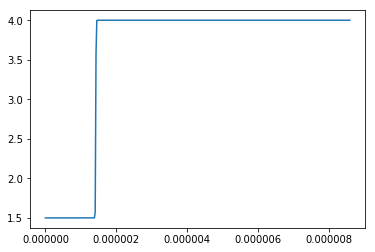

In [1]:
from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import constants
import os

output_folder = "other/ST-UX-Gauss"
save_size = 50    ### save this number of outputs to each output file 

n_dim = 3
r0, r1, dr = [None]*3
S = 0.9
n_t = None
save_every = 1

f_si = constants.c/(532*constants.nano)
print("f = {} THz".format(f_si/constants.tera))

f_nat = f_si/constants.c
print("f = {} m^-1  (natural units)".format(f_nat))

omega = 2.0*np.pi*f_nat


r_c = None
s_pml = None
d_pml = None

L_0 = 2.0*np.pi/omega


eps_r_0 = np.array([1.5, 1.5, 1.5])
eps_r_1 = np.array([4.0, 4.0, 9.0])
eps_r_max = max(np.max(np.abs(eps_r_0)), np.max(np.abs(eps_r_1)))
eps_r_min = min(np.min(np.abs(eps_r_0)), np.min(np.abs(eps_r_1)))
L_g = L_0/np.sqrt(eps_r_max)

def smoothswitch(t, f0=1, f1=2, alpha=1, t0=0):
    return f0 + 0.5*(1.0 + np.tanh(alpha*(t-t0)))*(f1 - f0)
alpha = 20.0/L_g
t0 = L_g*8

eps_r = [lambda r, t: smoothswitch(t, eps_r_0[0], eps_r_1[0], alpha, t0),
         lambda r, t: smoothswitch(t, eps_r_0[1], eps_r_1[1], alpha, t0),
         lambda r, t: smoothswitch(t, eps_r_0[2], eps_r_1[2], alpha, t0)]


if n_dim==3:
        r0 = np.array([0.0, 0.0, 0.0])
        r1 = np.array([1.2, 1.0, 1.0])*10.0*L_0
        ###@AA: n_resolution is the number of cells per wavelength
        ####  -----------   you can change n_resolution  --------------
        #n_resolution = 10
        n_resolution = 10
        dr = np.array([1.0, 1.0, 1.0])*L_0/n_resolution
        S /= np.sqrt(3)
        
        ###@AA: n_t is the number of time steps (total simulation time)
        #### if you doubled the resolution, also double n_t
        ####  -----------   you can change n_t  --------------
        #n_t = 240
        n_t = 380
        #n_t=250
        
        ###@AA: r_c is the center of the box
        r_c = (r0+r1)/2.0    
        
        ###@AA: PML thickness and attenuation factor
        d_pml = np.array([1.0, 1.0, 1.0])*L_0
        s_pml = np.array([1.0+1.0j, 1.0+1.0j, 1.0+1.0j])/d_pml*3.0
        
        
        ####@AA: r_eps_r_eps_0 and r_eps_1 are the corners of the slab
        ####     the faces of the slab are 1*L_0 away from the faces of the PML
        r_eps_0 = r0 + d_pml + np.array([1.0, 0.0, 0.0])*1*L_0
        r_eps_1 = r1 - d_pml - np.array([3.0, 0.0, 0.0])*1*L_0
        
        ###@AA: r_j is the position of the source plane
        r_j = r_c.copy()
        r_j[0] = (d_pml[0] + r_eps_0[0])/2

        ####@AA: transmission is recorded at a plane passing through r_t
        r_t = r_c.copy()
        r_t[0] = r_eps_1[0] + L_0/8

elif n_dim==2:
    assert False
    r0 = np.array([0.0, 0.0])
    r1 = np.array([1.0, 1.0])*10.0*L_0
    dr = np.array([1.0, 1.0])*L_0/30
    S /= np.sqrt(2)
    n_t = 2000
    
    r_c = (r0+r1)/2.0    
    d_pml = np.array([1.0, 1.0])*L_0
    s_pml = np.array([1.0+1.0j, 1.0+1.0j])/d_pml*3.0

    r_j = r_c.copy()
    r_j[0] = d_pml[0] + L_0/2

    r_t = r_c.copy()
    r_t[0] = r1[0] - d_pml[0] - L_0/2

elif n_dim==1:
    assert False
    
dt = S*dr[0]/np.sqrt(eps_r_min)
d_v = np.prod(dr)

print('dr : ', dr)
print('dt: ', dt)
print('S: ', S)


print((n_t*dt)/t0)
i_change = t0/dt/save_every
print("time index for medium change: ", i_change)

_t_samples_ = np.linspace(0.0, n_t*dt, n_t)
plt.plot(_t_samples_, eps_r[0](0,_t_samples_))
plt.show()


In [2]:

fdtd = FDTDSimulator(vbose=True)

fdtd.SetSimulationBox(r0, r1, dr, dt)
fdtd.save_every = save_every 

d_x_ = np.zeros(n_dim)
d_x_[0] = (r1[0]-r0[0])
d_x_pml = np.zeros(n_dim)
d_x_pml[0] = d_pml[0]

T_per = 2.0*np.pi/omega
t0_j = 2.0*T_per
T_j = 1.0*T_per
f_t = lambda t: np.exp(-(t - t0_j)**2/T_j**2)*np.sin(omega*(t - t0_j))

## J_e
W_G = 4*L_0
r_je = r_j.copy()
r_je[0] = np.floor(r_je[0]/dr[0])*dr[0]
r_je[1] = np.floor(r_je[1]/dr[1])*dr[1]+dr[1]/2
print('ind : ', np.floor(r_je[0]/dr[0]))
je_type = FVTypes.JeSheet
je_mag = None
if n_dim==2:
    je_mag = lambda r: 1.0/dr[0]*np.exp(-(r[1]-r_je[1])**2/W_G**2)
elif n_dim==3:
    je_mag = lambda r: 1.0/dr[0]*np.exp(-((r[1]-r_je[1])**2+(r[2]-r_je[2])**2)/W_G**2)

norm_dir = 'x'
je_args = {'r0':r_je, 'mag':je_mag, 'f_t':f_t, 'src_dir':'y', 'norm_dir':norm_dir}
fdtd.AddSources({'type':je_type, 'name':'Je_y', 'args':je_args})
je_args = {'r0':r_je, 'mag':je_mag, 'f_t':f_t, 'src_dir':'z', 'norm_dir':norm_dir}
fdtd.AddSources({'type':je_type, 'name':'Je_z', 'args':je_args})

## J_m
r_jm = r_je.copy()
r_jm[0] = r_je[0] - dr[0]/2
jm_type = FVTypes.JmSheet
jm_mag = None
if n_dim==2:
    jm_mag = lambda r: 1.0/dr[0]*np.exp(-(r[1]-r_jm[1])**2/W_G**2)
elif n_dim==3:
    jm_mag = lambda r: 1.0/dr[0]*np.exp(-((r[1]-r_jm[1])**2+(r[2]-r_jm[2])**2)/W_G**2)

norm_dir = 'x'
jm_args = {'r0':r_jm, 'mag':jm_mag, 'f_t':lambda t: f_t(t-dt/2), 'src_dir':'z', 'norm_dir':norm_dir}
fdtd.AddSources({'type':jm_type, 'name':'Jm_z', 'args':jm_args})
jm_args = {'r0':r_jm, 'mag':jm_mag, 'f_t':lambda t: -f_t(t-dt/2), 'src_dir':'y', 'norm_dir':norm_dir}
fdtd.AddSources({'type':jm_type, 'name':'Jm_y', 'args':jm_args})


eps_args = {'r0':r_eps_0, 'r1':r_eps_1, 'mag_in':eps_r, 'mag_out':[1.0, 1.0, 1.0]}
fdtd.AddMaterial({'type':FVTypes.EpsDiagSTvarBox, 'name':'eps', 'args':eps_args})
#fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps', 'args':eps_args})


pml_args = {'d_pml':d_pml, 's_pml':s_pml}
fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

set_eps_out = False

r_out = r_c

if n_dim==3:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'y', 'O_dir':'y', 'name':'Ey',\
                                                                 'save_folder':output_folder, 'save_size':save_size}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'z', 'name':'Ez',\
                                                                 'save_folder':output_folder, 'save_size':save_size}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_t, 'args':{'A':'E', 'A_dir':'y', 'O_dir':'x', 'name':'Ey_t',\
                                                                 'save_folder':output_folder, 'save_size':save_size}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_t, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'Ez_t',\
                                                                 'save_folder':output_folder, 'save_size':save_size}})
elif n_dim<=2:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'x', 'O_dir':None, 'name':'Ex'}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'y', 'O_dir':None, 'name':'Ey'}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'Ez'}})

        
fdtd.StepFields(n_t)
n_saved = fdtd.n_saved
    


ind :  14.0
self.E[0].shape: (119, 101, 101)
self.D[0].shape: (119, 101, 101)
self.B[0].shape: (120, 100, 100)
self.H[0].shape: (120, 100, 100)
self.Je_y[0].shape: (119, 101, 101)
sides inds_min_x: (13, 50, 50) d: 3.36224200204e-08
sides inds_min_y: (14, 50, 50) d: 6.25882352941e-09
sides inds_min_z: (14, 50, 50) d: 3.81351920406e-08
self.Je_z[0].shape: (119, 101, 101)
sides inds_min_x: (13, 50, 50) d: 3.36224200204e-08
sides inds_min_y: (14, 50, 50) d: 6.25882352941e-09
sides inds_min_z: (14, 50, 50) d: 3.81351920406e-08
self.Jm_z[0].shape: (120, 100, 100)
face inds_min_x: (13, 50, 50) d: 3.37596019918e-08
face inds_min_y: (13, 50, 50) d: 3.80991440204e-08
face inds_min_z: (13, 50, 50) d: 6.03529411765e-09
self.Jm_y[0].shape: (120, 100, 100)
face inds_min_x: (13, 50, 50) d: 3.37596019918e-08
face inds_min_y: (13, 50, 50) d: 3.80991440204e-08
face inds_min_z: (13, 50, 50) d: 6.03529411765e-09
self.eps[0].shape: (119, 101, 101)
sides inds_min_x: (59, 50, 50) d: 4.23516473627e-22
sides i

In [3]:
import matplotlib.pyplot as plt

r_E, E_out_list = None, None
x_E, y_E, z_E = [None]*3
ind_file_loaded = None
ind_file_max = None
e_max = None
E_out_str =  "Ey"

def load_file_data(ind_file):
    global r_E, E_out_list, x_E, y_E, z_E, ind_file_loaded, ind_file_max, e_max, E_out_str
    r_E, E_out_list, ind_file_max = fdtd.GetOutputs(E_out_str, ind_file)
    if n_dim==3:
        x_E, y_E, z_E = r_E
        print('x_E.shape : ', x_E.shape)
        print('y_E.shape : ', y_E.shape)
        print('z_E.shape : ', z_E.shape)
        print('E_out_list[0].shape : ', np.array(E_out_list[0]).shape)
    elif n_dim==2:
        x_E, y_E = r_E
    elif n_dim==1:
        x_E = r_E[0]
    e_max = [np.max(np.abs(e)) for e in E_out_list]
    print('max(e_max):', max(e_max))
    e_max = max(e_max)
    
    ind_file_loaded = ind_file
    print('File loaded : ', ind_file_loaded)
    
load_file_data(0)
print('Number of files: ', ind_file_max)
print('File loaded : ', ind_file_loaded)


Saved outputs: dict_keys(['Ez', 'Ey_t', 'Ey', 'Ez_t'])
x_E.shape :  (120, 101)
y_E.shape :  (120, 101)
z_E.shape :  (120, 101)
E_out_list[0].shape :  (120, 101)
max(e_max): 1.0362426044
File loaded :  0
Number of files:  8
File loaded :  0


In [4]:
%matplotlib tk

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

# Set up formatting for the movie files
#Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
#writer = Writer(fps=15, metadata=dict(artist='Me'))
#writer = animation.FFMpegWriter()

plt.rcParams["figure.figsize"] = (5, 5)

plt_field = 'E'
save_anim = False
file_format = 'gif'   ## 'gif' / 'mp4'

logscale=False
log_0 = np.log(e_max)-20

use_subplots = False

font = {'family' : 'serif', 'weight' : 'normal', 'size' : 14}
matplotlib.rc('font', **font)

shape_E = np.array(E_out_list[0]).shape
_x_ = np.linspace(r0[0], r1[0], shape_E[0]+1)
_y_ = np.linspace(r0[1], r1[1], shape_E[1]+1)
print('r0', r0, 'r_eps_0: ', r_eps_0)
print('r1', r1, 'r_eps_1: ', r_eps_1)

fig = None
if n_dim>=2:
    def animate_E(i):
        
        ind_file = i//save_size
        ind = i%save_size
        
        if ind_file_loaded!=ind_file:
            load_file_data(ind_file)
            
        E_out_list[ind] = np.array(E_out_list[ind])
        #print(E_out_list[ind])
        
        plt.clf()
        #fig = plt.pcolor(y_E, z_E, E_out_list[i])
        if not logscale:
            #fig = plt.imshow(E_out_list[ind].T, origin='lower', vmin=-1, vmax=1, cmap='rainbow', aspect='auto')
            fig = plt.gca().pcolorfast(_x_, _y_, E_out_list[ind].T, vmin=-0.7, vmax=0.7, cmap='rainbow')
            
        else:
            E_log = np.log(np.abs(E_out_list[ind]))
            E_log = (E_log>=log_0)*E_log + (E_log<log_0)*(log_0)
            fig = plt.imshow(E_log.T, origin='lower', vmin=log_0, vmax=np.log(e_max), cmap='rainbow', \
                             aspect='auto')

        #CB = plt.colorbar(fig, shrink=0.8, extend='both')
        ax = plt.gca()
        ax.set_adjustable('box-forced')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        #plt.colorbar()
        
        vline_color = 'k'
        if i<i_change:
            vline_color = 'r'

        plt.axvline(x=r_eps_0[0], ymin=r_eps_0[1]/r1[1], ymax=r_eps_1[1]/r1[1], linestyle='-.', color=vline_color)
        plt.axvline(x=r_eps_1[0], ymin=r_eps_0[1]/r1[1], ymax=r_eps_1[1]/r1[1], linestyle='-.', color=vline_color)
        
        if i%10==0:
            print("{}/{}".format(i, n_saved), end=" ")
        return fig

    fig = plt.figure()
    axes = plt.gca()
    anim = None
    if plt_field=='E':
        anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1, repeat=False)
    else:
        raise ValuError()

    if save_anim:
        if file_format=='gif':
            anim.save('other/e-2d.gif', writer="imagemagick", fps=15, dpi=200)
        elif file_format=='mp4':
            anim.save('other/e-2d.mp4', writer="mencoder", fps=15, dpi=200)
    plt.show()

    

r0 [ 0.  0.  0.] r_eps_0:  [  1.06400000e-06   5.32000000e-07   5.32000000e-07]
r1 [  6.38400000e-06   5.32000000e-06   5.32000000e-06] r_eps_1:  [  4.25600000e-06   4.78800000e-06   4.78800000e-06]
0/380 0/380 10/380 20/380 30/380 40/380 Saved outputs: dict_keys(['Ez', 'Ey_t', 'Ey', 'Ez_t'])
x_E.shape :  (120, 101)
y_E.shape :  (120, 101)
z_E.shape :  (120, 101)
E_out_list[0].shape :  (120, 101)
max(e_max): 1.08768835211
File loaded :  1
50/380 60/380 70/380 80/380 90/380 Saved outputs: dict_keys(['Ez', 'Ey_t', 'Ey', 'Ez_t'])
x_E.shape :  (120, 101)
y_E.shape :  (120, 101)
z_E.shape :  (120, 101)
E_out_list[0].shape :  (120, 101)
max(e_max): 0.543531165657
File loaded :  2
100/380 110/380 120/380 130/380 140/380 Saved outputs: dict_keys(['Ez', 'Ey_t', 'Ey', 'Ez_t'])
x_E.shape :  (120, 101)
y_E.shape :  (120, 101)
z_E.shape :  (120, 101)
E_out_list[0].shape :  (120, 101)
max(e_max): 0.450890089316
File loaded :  3
150/380 160/380 170/380 

In [8]:
### write to csv
import os

E_out_str =  "Ey"
def save_as_csv(csv_name):
    file_csv_name = os.path.join(output_folder, csv_name+".csv")
    if os.path.exists(file_csv_name):
        os.remove(file_csv_name)
    file_csv = open(file_csv_name, 'ab')

    for ind_file in range(ind_file_max):
        load_file_data(ind_file)
        for ind in range(len(E_out_list)):
            A = np.array(E_out_list[ind])
            np.savetxt(file_csv, A, delimiter=",", fmt="%.10e")

    file_csv.close()


E_out_str =  "Ey"
save_as_csv(E_out_str)
E_out_str =  "Ez"
save_as_csv(E_out_str)
E_out_str =  "Ey_t"
save_as_csv(E_out_str)
E_out_str =  "Ez_t"
save_as_csv(E_out_str)


Saved outputs: dict_keys(['Ey_t', 'Ez_t', 'Ez', 'Ey'])
x_E.shape :  (101, 101)
y_E.shape :  (101, 101)
z_E.shape :  (101, 101)
E_out_list[0].shape :  (101, 101)
max(e_max): 0.777839924708
File loaded :  0
Saved outputs: dict_keys(['Ey_t', 'Ez_t', 'Ez', 'Ey'])
x_E.shape :  (101, 101)
y_E.shape :  (101, 101)
z_E.shape :  (101, 101)
E_out_list[0].shape :  (101, 101)
max(e_max): 0.891393805697
File loaded :  1
Saved outputs: dict_keys(['Ey_t', 'Ez_t', 'Ez', 'Ey'])
x_E.shape :  (101, 101)
y_E.shape :  (101, 101)
z_E.shape :  (101, 101)
E_out_list[0].shape :  (101, 101)
max(e_max): 0.865848562489
File loaded :  2
Saved outputs: dict_keys(['Ey_t', 'Ez_t', 'Ez', 'Ey'])
x_E.shape :  (101, 101)
y_E.shape :  (101, 101)
z_E.shape :  (101, 101)
E_out_list[0].shape :  (101, 101)
max(e_max): 0.749729631571
File loaded :  3
Saved outputs: dict_keys(['Ey_t', 'Ez_t', 'Ez', 'Ey'])
x_E.shape :  (101, 101)
y_E.shape :  (101, 101)
z_E.shape :  (101, 101)
E_out_list[0].shape :  (101, 101)
max(e_max): 0.59714